# Clap timing review

Something has gone wronge when trying to align the measured claps from the audience motion data to the audio recording time line. In order to document the interaction of the audience and the stage, this alignement is very important: We need to ensure the alignment in error free and that the limit of precision is clearly documented.

This notebook repeats the extraction of the claps from individual participants with clean code to make the reliability clear and verifiable.

## Prep libraries, directories, definitions

In [21]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import imageio

# dependencies
from scipy.signal import find_peaks

pd.options.mode.chained_assignment = None

In [22]:
# import activity analysis functions from aa.py file in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport aa

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
%reload_ext autoreload

In [24]:
def rms_signal(data, window_size, shift):
  # data is pandas Series of signal
  # function to calculate root mean square using a scrolling window.
  i = int(window_size/2)
  l = data.shape[0]
  rms_y = [np.nan]*l

  while True:
    if i >= l:
      break

    if (i >= window_size/2) and (l-i >= window_size/2):
      in_window  = int(i-window_size/2)
      out_window = int(i+window_size/2)

      data_rms = data.iloc[in_window:out_window]
      if data_rms.isna().sum() < (len(data_rms)):
        data_rms = data_rms.dropna()
      rms_value = math.sqrt(sum([i*i for i in data_rms])/len(data_rms)) if data_rms.isna().sum() == 0 else -1

    else:
      rms_value = np.nan

    rms_y[i] = rms_value
    i = i + shift

  df = pd.DataFrame(index = data.index, columns = ['rms'], data={'rms': rms_y})
  return df

def butter_lowpass_filter(data, cutoff, fs, order):
  normal_cutoff = cutoff / nyq
  b, a = butter(order, normal_cutoff, btype='low', analog=False)
  y = filtfilt(b, a, data)
  return y

# NEW NO PD APPEND
def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and/or time_concert which is used to ID gaps greater than gap_T
    # gap_T is in milliseconds (ms)
    # rows of NaN data is added to non-time columns before the first sample, at edges of each gap, and after the last sample of data
    # these nans prevent interpolation errors through missing data
    cols = data.columns
    if 'time' in cols:
        time_col = 'time'
    if 'time_concert' in cols:
        time_col = 'time_concert'
        
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    dt = data[time_col].diff()    
    gapsi = np.array(dt[dt>gap_t].index)
    a = np.append(gapsi-1,dt.index[-1])
    gapsd = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsd[c] = data.loc[a,c]+dtdeltat
        if c.startswith('time'):
            gapsd[c] = data.loc[a,c]+deltat 

    a = np.append(gapsi,dt.index[0])
    gapsp = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsp[c] = data.loc[a,c]-dtdeltat
        if c.startswith('time'):
            gapsp[c] = data.loc[a,c]-deltat 

    data = pd.concat([gapsp,gapsd,data]).sort_values(time_col,ignore_index=True)
    return data

In [25]:
# Now to map those values to locations, need to import some details.
# these are old ID codes, need to replace. 
general_loc = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/'

internal_mlmotion = general_loc + 'Internal/Motion_ML/'
internal_ax3 = general_loc +  'Internal/Motion_AX3/'
internal_Part = general_loc + 'Internal/Participants/'
internal_time = general_loc + 'Internal/Timing/'

public_mlmotion = general_loc + 'Public/Motion_ML/'
public_ax3 = general_loc +  'Public/Motion_AX3/'
public_Part = general_loc + 'Public/Participants/'
public_time = general_loc + 'Public/Timing/'

clap_singles = 'C:/Users/finnu/dev/Clapping_Coordination/Clean_Claps/Singles'
clap_sets = 'C:/Users/finnu/dev/Clapping_Coordination/Clean_Claps/Sets'

In [26]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'] == 'A',:] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts

,Participant_Code,Participant_Number,Attendance,Questionnaire_Language,Motion_Quality,Link_Conflicts,Seat_Zone,Location,Longitude_Truncated,Lattitude_Truncated,Offset_1,Offset_2,Watch_Alone
0,ADQ001,1,A,D,Q,0,6.0,NaN,NaN,NaN,0.14,0.16,0.0
1,ADQ002,2,A,D,Q,0,3.0,NaN,NaN,NaN,NaN,-0.36,0.0
2,ADQ003,3,A,D,Q,0,2.0,NaN,NaN,NaN,0.88,1.02,0.0
3,ADQ004,4,A,D,Q,0,4.0,NaN,NaN,NaN,0.44,0.62,1.0
4,ADQ005,5,A,D,Q,0,4.0,NaN,NaN,NaN,0.04,0.12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,AEQ086,86,A,E,Q,0,5.0,NaN,NaN,NaN,NaN,0.34,0.0
81,AEQ087,87,A,E,Q,1,3.0,NaN,NaN,NaN,0.12,0.28,0.0
82,AEQ088,88,A,E,Q,0,2.0,NaN,NaN,NaN,0.10,0.06,0.0
83,AEQ089,89,A,E,Q,0,4.0,NaN,NaN,NaN,0.28,0.38,0.0


## Load times and sample claps set

In [28]:
applause_times = pd.read_csv('data/Applause_Moments.csv',sep=",") #SV alignment for beeps
applause_times
# correctd Applause times concert_times. original file (0_App...) off by 5 seconds too late

,Stream_Time,concert_time,Applause_N,Event,Event_Type,Sequence
0,945.9,-693.3,0,Musicians enter hall,Musician_act,0.000
1,946.0,-693.2,0,Clapping Start,First_Clap,0.100
2,963.0,-676.2,0,Musicians seated,Musician_act,17.000
3,963.1,-676.2,0,Clapping End,Last_Clap,0.088
4,1081.0,-558.2,1,Last word V,Speach,117.936
...,...,...,...,...,...,...
99,9757.0,8117.8,14,Bow 5,Musician_act,7.000
100,9774.0,8134.8,14,Bow 6,Musician_act,17.000
101,9776.0,8136.8,14,Start to leave stage,Musician_act,2.000
102,9783.0,8143.8,14,Out of sight,Musician_act,7.000


In [29]:
applause_times['Stream_Time'] - applause_times['concert_time']

0      1639.2
1      1639.2
2      1639.2
3      1639.3
4      1639.2
        ...  
99     1639.2
100    1639.2
101    1639.2
102    1639.2
103    1639.2
Length: 104, dtype: float64

In [30]:
df_clappings['start_time']-df_clappings['start_time_concert']

0     1639.24
1     1639.24
2     1639.24
3     1639.24
4     1639.24
5     1639.24
6     1639.24
7     1639.24
8     1639.24
9     1639.24
10    1639.24
11    1639.24
12    1639.24
13    1639.24
14    1639.24
dtype: float64

In [31]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)

# concert times 50 Hz
ts_ct = np.arange(-1086,9715, 0.02)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')

In [32]:
concert_times = pd.read_csv(public_time +'Concert_Events_On_Off.csv',sep=",") #SV alignment for beeps
concert_times['sequence'] = concert_times.index
concert_times.set_index('Time_dt_Start',inplace = True)
concert_times.iloc[:5]

concert_applause = concert_times.loc[concert_times['Event_Type']=='Applause',:]
# music preceding Claps 4, 6, 8, 10-15
concert_applause

df_clappings = pd.DataFrame(columns = ['section_id','start_time_concert','start_time','end_time_concert','end_time','tag','clapping_type'])
tags = ['Concert begins','Clapping Between Speeches 1','Clapping After Introduction','Beethoven Applause','Musicians Return 1','Schnittke Applause','Musicians Return 2','Bach Applause','Folk Music 1 Applause','Folk Music 2 Applause','Folk Music 3 Applause','Folk Music 4 Applause','Folk Music 5 Applause','Clapping Between Speeches 2','Final Applause']
# cue_tags = ['Musicians Enter Hall','Last word','Last word','Last Note' ]
# cue_time = [-694.50,-558.24,29.46,1607.21,]
df_clappings['section_id'] = range(len(tags))
df_clappings['start_time_concert'] = concert_applause['Time_s_Start'].values
df_clappings['start_time'] = concert_applause['Time_Stream_Start'].values
df_clappings['end_time_concert'] = concert_applause['Time_s_End'].values
df_clappings['end_time'] = concert_applause['Time_Stream_End'].values
df_clappings['tag'] = tags
df_clappings['clapping_type'] = [1,1,1,2,1,2,1,2,3,3,3,3,3,1,4]
df_clappings

,section_id,start_time_concert,start_time,end_time_concert,end_time,tag,clapping_type
0,0,-693.24,946.00,-676.16,963.08,Concert begins,1
1,1,-558.04,1081.20,-550.12,1089.12,Clapping Between Speeches 1,1
2,2,28.44,1667.68,38.36,1677.60,Clapping After Introduction,1
3,3,1608.52,3247.76,1649.88,3289.12,Beethoven Applause,2
4,4,2002.68,3641.92,2014.46,3653.70,Musicians Return 1,1
5,5,3280.54,4919.78,3340.98,4980.22,Schnittke Applause,2
6,6,4999.90,6639.14,5017.56,6656.80,Musicians Return 2,1
7,7,6017.66,7656.90,6039.78,7679.02,Bach Applause,2
8,8,6757.04,8396.28,6774.54,8413.78,Folk Music 1 Applause,3
9,9,6931.24,8570.48,6950.80,8590.04,Folk Music 2 Applause,3


In [33]:
applause_times.loc[applause_times['Applause_N']==1,:]

,Stream_Time,concert_time,Applause_N,Event,Event_Type,Sequence
4,1081.0,-558.2,1,Last word V,Speach,117.936
5,1081.2,-558.1,1,Clapping Start,First_Clap,0.166
6,1087.1,-552.2,1,Clapping End,Last_Clap,5.890
7,1087.1,-552.2,1,MC starts talking,Speach,0.000


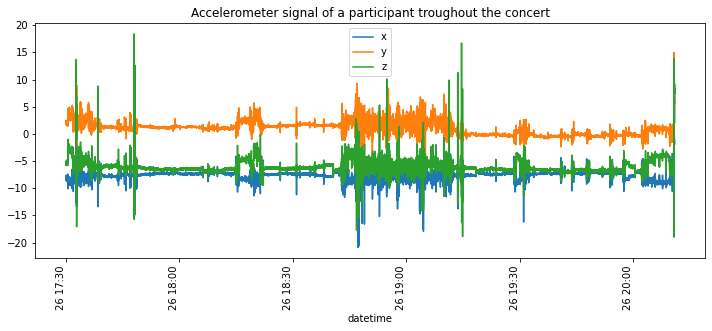

In [34]:
i = 11
participant = alignedParts.loc[i,:]

part = participant['Participant_Code']
if part[2]=='Q': # Motionlab phone acc
    inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
else: # AX3
    inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format


inst_d.plot(x='datetime', y=['x','y','z'], figsize=(12,4.8), title='Accelerometer signal of a participant troughout the concert')
plt.xticks(rotation=90)
plt.show()

In [40]:
inst_d.loc[:5,:]
# time is milliseges

,time,datetime,x,y,z,alpha,beta,gamma,device_timestamps
0,-1085993.0,2021-10-26 17:30:00.007,-7.9,2.3,-5.4,-0.5,2.6,0.3,1635269399167
1,-1085977.0,2021-10-26 17:30:00.023,-7.9,2.3,-5.3,-0.5,2.4,0.4,1635269399183
2,-1085960.0,2021-10-26 17:30:00.040,-7.8,2.2,-5.4,-0.7,-0.3,0.2,1635269399200
3,-1085943.0,2021-10-26 17:30:00.057,-7.9,2.2,-5.5,-1.5,-1.6,0.0,1635269399217
4,-1085927.0,2021-10-26 17:30:00.073,-7.9,2.2,-5.5,-1.2,-1.0,0.2,1635269399233
5,-1085910.0,2021-10-26 17:30:00.090,-7.9,2.3,-5.5,0.4,-0.4,0.2,1635269399250


In [37]:
# transfer to a consistent samples rate
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 100
datas = gap_nans(inst_d,gap_t)
#get concert time
resampled = pd.DataFrame(index = ts_ct)
cols = datas.columns
for col in cols[1:]:
    f = interp1d(datas['time'], datas[col],fill_value='extrapolate')
    resampled[col] = f(ts_ct)

# extract 1D accelerometer feature for easy comparison
# and basic normalisation
b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
if part[2]=='Q':
    aud_df[part] = b
else:
    aud_df[part] = b*8
aud_df.index = dt_ct

In [38]:
full_motion_50hz_df = aud_df.copy()
full_motion_50hz_df.index = ts_ct

In [39]:
df_clappings.loc[14]

section_id                        14
start_time_concert           8040.24
start_time                   9679.48
end_time_concert             8147.28
end_time                     9786.52
tag                   Final Applause
clapping_type                      4
Name: 14, dtype: object

## Output claps to Singles

## Output claps to Sets for future use